In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy

import torch
from utils import MyDataset
from model import generate, my_model, my_flow_model 

from matplotlib.colors import LogNorm

gpu_id = 0
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")

def plot_running_mean(x, y, window_size, show_diff=False, **kwargs):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    y = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    if not (len(y) > 0):
        print("No data to plot.")
        return None

    if show_diff:
        y -= y.min()
        plt.yscale("log")

    line = plt.plot(x[:len(y)], y, **kwargs)
    return line
        

In [11]:
model_dir = "./output/transformer1_conditional_bimodal_nc16_nl6_nf6_ep100_lr2e-4"

#model_dir = "./output/transformer2"
#model_dir = "./output/transformer3"
#model_dir = "./output/best"

### load parameters
with open(f"{model_dir}/args.json", "r") as f:
    opt = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
print("opt: ", opt)

norm_params = np.loadtxt("norm_params.txt")
xmin = norm_params[:,0]
xmax = norm_params[:,1]


opt:  Namespace(gpu_id=1, output_dir='./output/transformer1_conditional_bimodal_nc16_nl6_nf6_ep100_lr2e-4', max_length=40, use_dist=True, use_vel=True, seed=12345, data_dir='./TNG_data', train_ratio=0.9, batch_size=1024, num_epochs=100, lr=0.0002, dropout=0.2, use_sampler=True, save_freq=20, load_epoch=0, model_name='transformer1', d_model=128, num_layers=6, num_heads=8, base_dist='gaussian', num_context=16, hidden_dim=64, num_flows=6, lambda_stop=1, hidden_dim_stop=64, verbose=False, num_condition=1, num_features=4, norm_params=[[11.0, 15.0], [-1.2, 3.0], [-3.0, 1.0], [-4.0, 4.0], [0.5, 4.0]])


In [12]:
### True data ###
ndata = None
#ndata = 10000

dataset_true = MyDataset(f"./TNG_data", max_length=opt.max_length, norm_params=norm_params, ndata=ndata, use_dist=opt.use_dist, use_vel=opt.use_vel)
x_true = dataset_true.x
y_true = dataset_true.y_padded
x_true_Msun = x_true * (xmax - xmin) + xmin

mask = dataset_true.mask

x_true = x_true[:,0].detach().cpu().numpy() # (batch, num_condition) -> (batch,)

### set threshold
threshold = ( np.log10(0.1) - xmin[1] ) / ( xmax[1] - xmin[1] )
print(threshold)

def calc_length(x, ref_param=0, skip_length=1):
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features)
    num_samples, seq_length, num_features = x.shape
    length = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        for j in range(skip_length, seq_length):
            if x[i,j,ref_param] < threshold:
                break
        length[i] = j
    return length

### calculate length ###
length_true = calc_length(y_true)

### binning ###
nbins = 20
x_bins = np.linspace(0, 1, nbins+1)
x_bins_physical_unit = x_bins[:,None] * (xmax[None,:] - xmin[None,:]) + xmin[None,:]

x_bin_indices_true = np.digitize(x_true, x_bins) - 1 # (num_samples,)
y_bin_indices_true = np.digitize(y_true, x_bins) - 1 # (num_samples, seq_length, num_params)
 
length_bins = np.arange(1, opt.max_length+1)
length_bin_indices_true = np.digitize(length_true, length_bins) - 1 # (num_samples,)

/tmp/ipykernel_829953/1496405639.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_true_Msun = x_true * (xmax - xmin) + xmin


0.04761904761904761


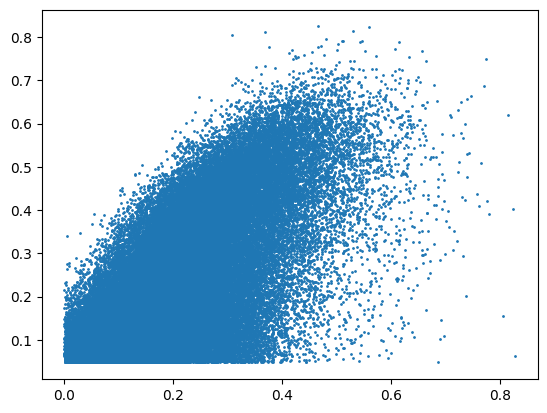

In [15]:
mask_now = (mask[:,1,0] == True)
xnow = x_true[mask_now]
ynow = y_true[mask_now]
plt.scatter(xnow, ynow[:,1,0], s=1)

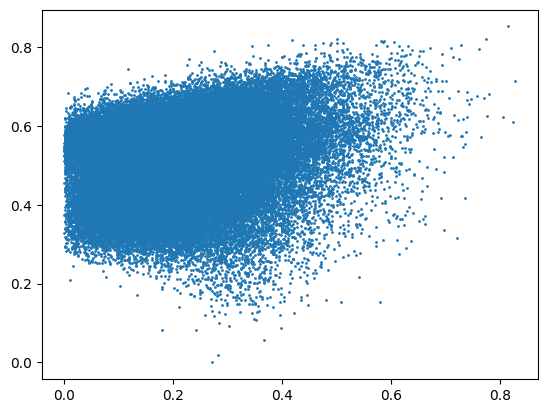

In [4]:
mask_now = (mask[:,1,0] == True)
xnow = x_true[mask_now]
ynow = y_true[mask_now]
plt.scatter(xnow, ynow[:,1,1], s=1)

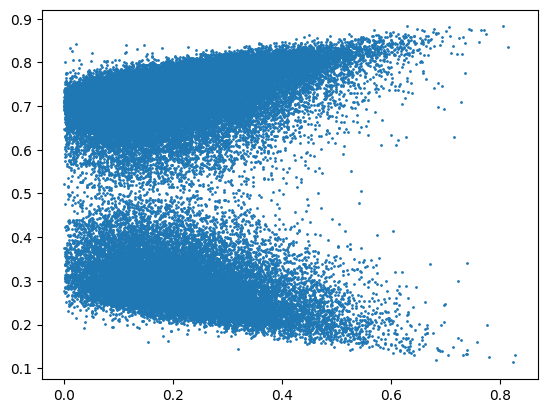

In [5]:
mask_now = (mask[:,1,0] == True)
xnow = x_true[mask_now]
ynow = y_true[mask_now]
plt.scatter(xnow, ynow[:,1,2], s=1)

#plt.scatter(x_true, y_true[:,0,2], s=1)

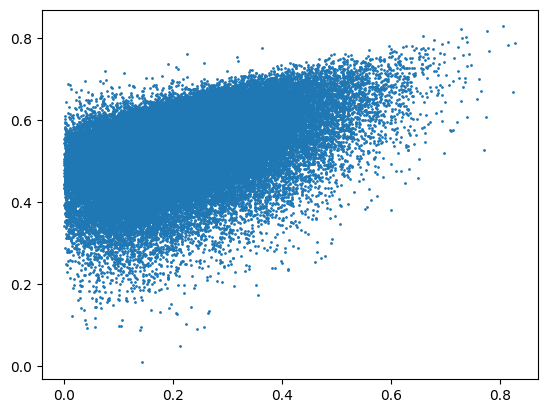

In [13]:
mask_now = (mask[:,1,0] == True)
xnow = x_true[mask_now]
ynow = y_true[mask_now]
plt.scatter(xnow, ynow[:,1,3], s=1)

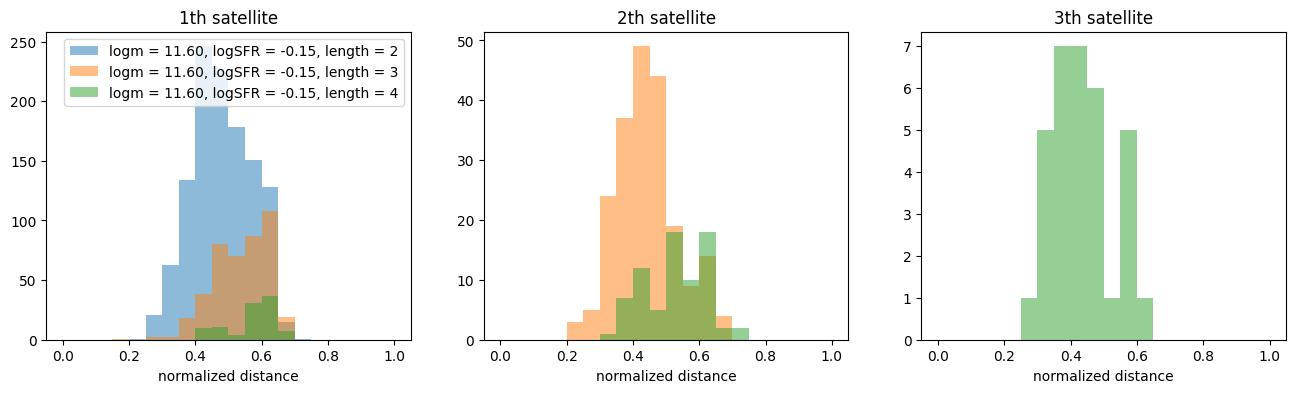

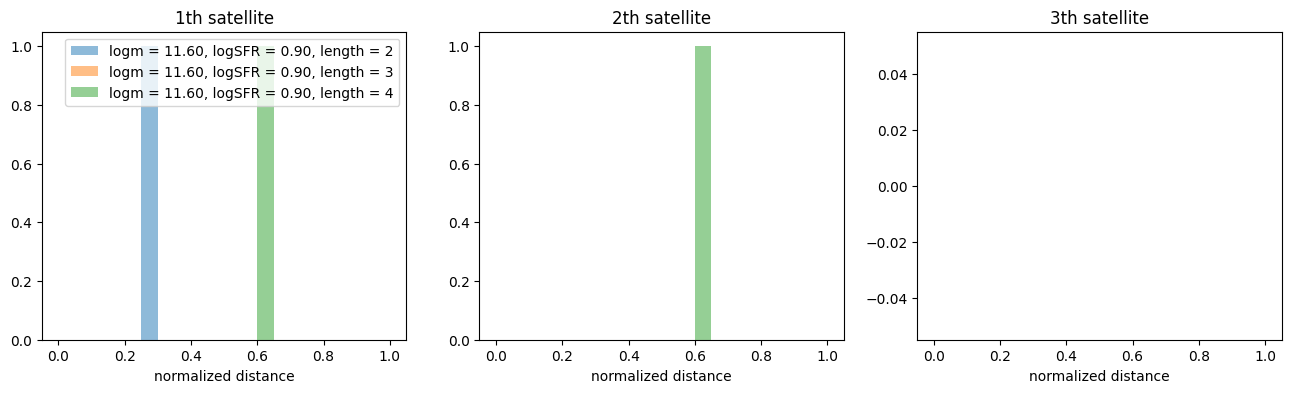

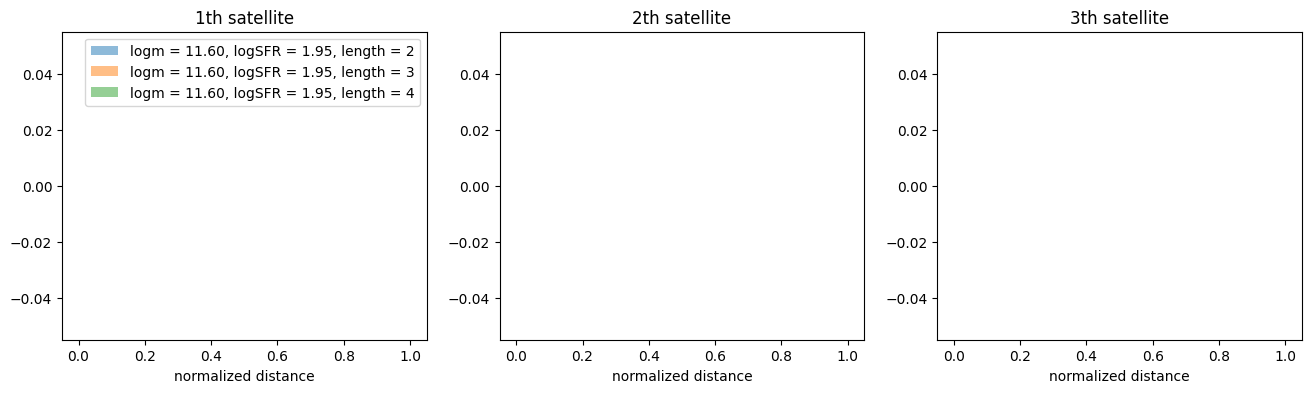

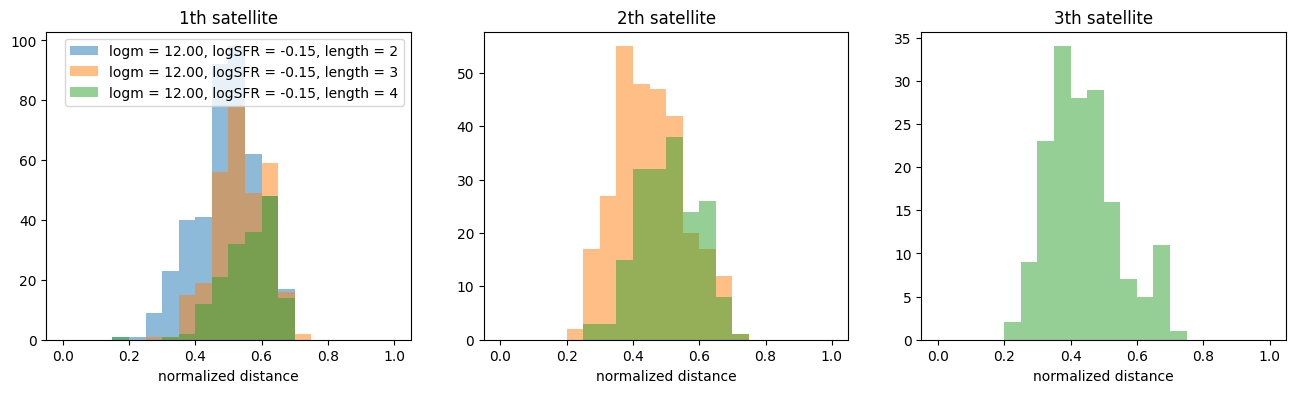

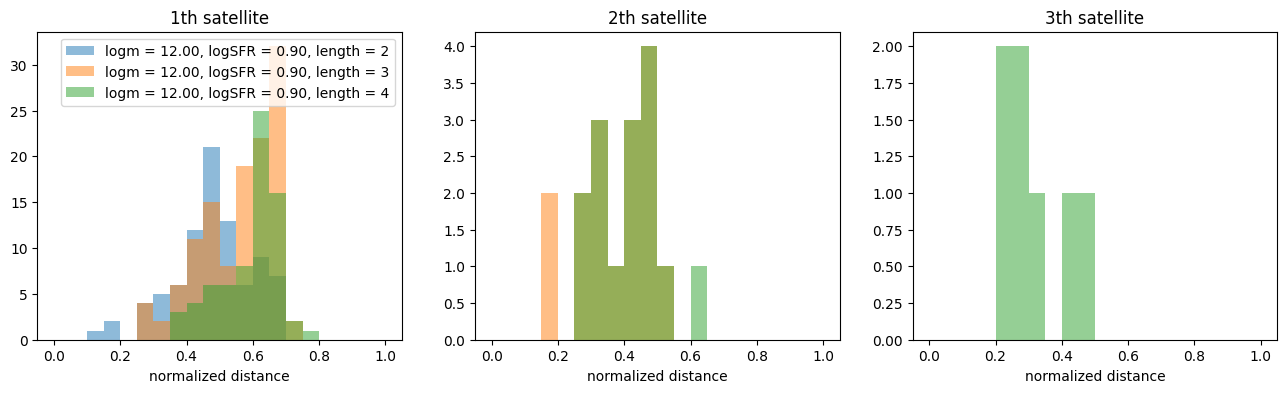

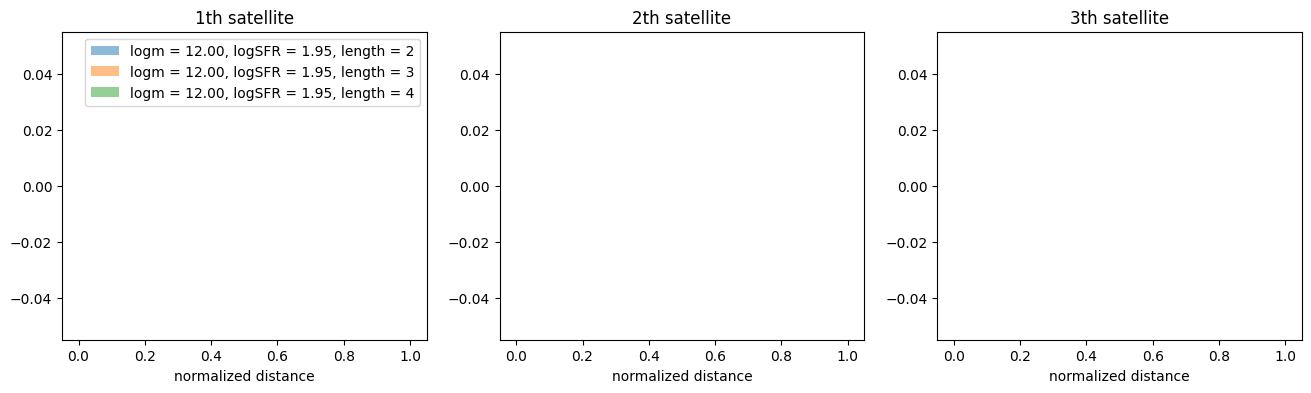

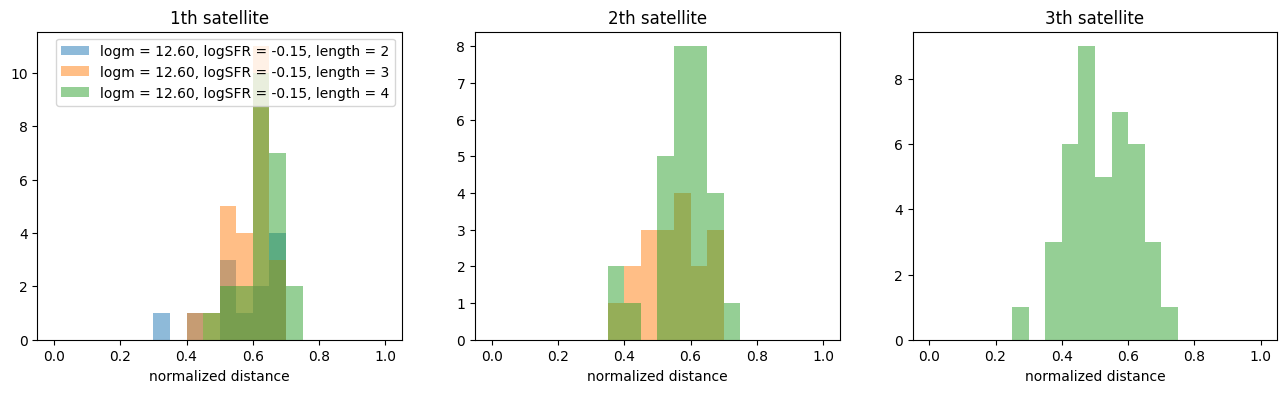

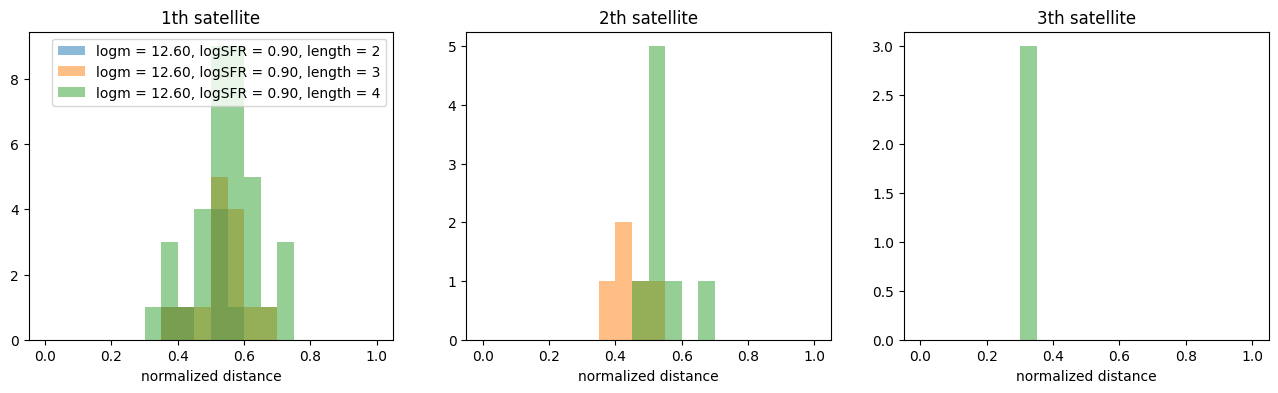

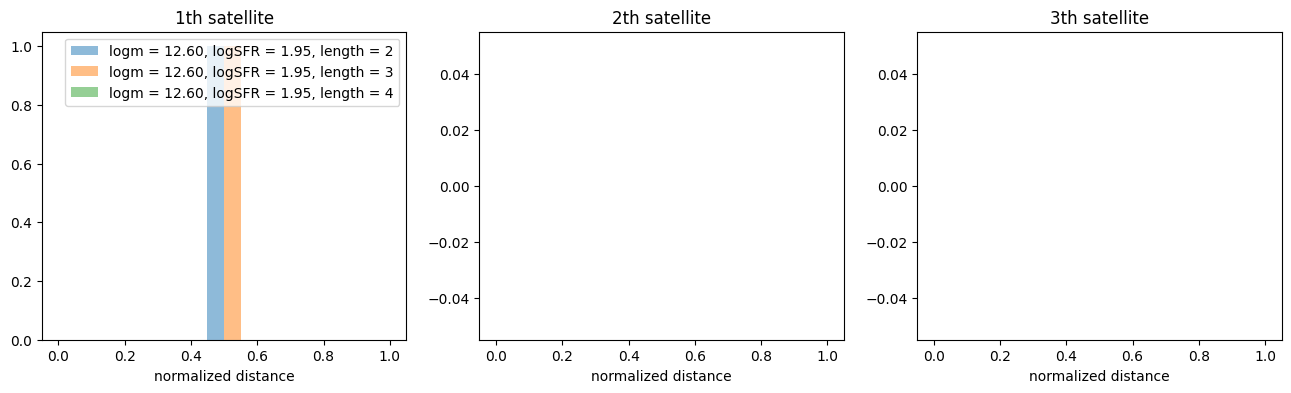

In [30]:
# Check correlations in true data

# For fixed halo mass and SFR
bin_to_show = [3, 5, 8]
bin_sfr_to_show = [5, 10, 15]
bin_length_to_show = [1, 2, 3]
max_length_to_show = 4
for i in bin_to_show:
    for j in bin_sfr_to_show:
        plt.figure(figsize=(max_length_to_show*4, 4))
        for i_rank in range(1, max_length_to_show): 
            plt.subplot(1, max_length_to_show-1, i_rank)
            plt.title(f"{i_rank}th satellite")
            for i_length in bin_length_to_show:
                mask_now = (x_bin_indices_true == i) & (y_bin_indices_true[:,i_rank,0] == j) & (length_bin_indices_true == i_length)
                plt.hist(y_true[mask_now, i_rank, 1], bins=x_bins, label=f"logm = {x_bins_physical_unit[i,0]:.2f}, logSFR = {x_bins_physical_unit[j,1]:.2f}, length = {length_bins[i_length]:d}", alpha=0.5)

            plt.xlabel("normalized distance")
            
            if i_rank == 1:
                plt.legend()
    